# Genoa: A brief review of genetic operators
---
Genetic Algorithms (GA) are based on the Darwinian concept of natural selection and can be used to solve search and optimisation problems. The algorithm can be described in the following steps:

  - Create a population of individuals whose genes encode a random solution to the problem.
  - Evaluate each individual's _fitness_ to solve the problem.
  - Replace a proportion of the worst performing section of the population. The replacement children are created by selecting one or two parents, based on their fitness, and their genes are mixed or modified using genetic operators.
  - Genetic operators come in two main flavours - mutators and crossovers. Mutator take one parent and change a small section of its genes. Crossovers take two (or more?) parents and splice their genes together.
  - The new children are evaluated and the process repeated by evolving the population over several generations.

## genoa

[genoa](https://github.com/cdragun/genoa) is a GA package written in Python which implements the following two encodings of the genotype:

  - FloatIndividual: the chromosome is a list of floats. This can be used in numerical optimisation and regression type of applications
  - OrderedIndividual: the genes encode an ordered set of items - used in schedule or sequence optimisation problems

---

Author: Chandranath Gunjal, 2018

---

The below analysis is based on the OrderedIndividual encoding which has been applied to the Travelling Salesman Problem. To start, let us import some modules we need...


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
from collections import Counter

sns.set()
sns.set_style('white')

## The Travelling Salesman Problem
***
[Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem) describes the travelling salesman problem (TSP) as:
> Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?

Given N cities, there are (N-1)! possible tours through them - assuming asymmetry in paths i.e. for a pair of cities A & B, the distance from A to B might not be the same as distance from B to A. If the paths are symmetric, there are only half the number of possible tours.

So for a 10-city problem, any algorithm has to find the shortest among ~363,000 possible routes; which quickly grows to 9.3e+155 for a 100-city problem.

A number of algorithms and heuristics to find the solution to the TSP are described in the Wikipedia article and some of these have been explored by [Peter Norvig](http://norvig.com) - from whom I have borrowed a few concepts.

The [University of Waterloo](http://www.math.uwaterloo.ca/tsp/index.html) site has a large collection of problem sets from which I have taken the following for this analysis:

| Dataset  | Region         | Num. Cities | Optimal tour | Possible routes |
|:---------|---------------:|------------:|-------------:|----------------:|
| wi29.tsp | Western Sahara | 29          | 27,603       | 3.0e+29         |
| qa194.tsp| Qatar          | 194         | 9,352        | 6.9e+358        |
| uy734.tsp| Uruguay        | 734         | 79,114       | 4.0e+1783       |


Let us define each city as a Point and load in the Western Sahara dataset...


In [2]:
class Point(complex):
    """2-D point"""
    x = property(lambda self: self.real)
    y = property(lambda self: self.imag)

    def __repr__(self):
        return 'Point({}, {})'.format(self.x, self.y)

    def __iter__(self):
        yield self.x
        yield self.y

def distance(a, b):
    """Return the distance between two points (rounded as per TSP datafile)"""
    return int(abs(a - b) + 0.5)

def load_tsp_data(filename):
    """Load tsp datafile and return a list of points"""
    pts = []
    tag_found = False

    with open(filename, "r") as fh:
        for line in fh:
            if re.match('EOF', line):
                break

            if re.match('EDGE_WEIGHT_TYPE', line):
                _, t = line.strip().split(': ')
                if t != 'EUC_2D':
                    raise TypeError('TSP format not supported: {}'.format(t))
                continue

            if re.match('NODE_COORD_SECTION', line):
                tag_found = True
                continue

            if not tag_found:
                continue

            # load the coordinates
            _, x, y = line.strip().split()
            pts.append(Point(float(x), float(y)))
    return pts

def tour_length(cities, tour):
    """Return the total length of a given tour"""
    return sum(distance(cities[tour[i - 1]], cities[tour[i]])
               for i in range(len(tour)))

def plot_lines(points, style='bo-'):
    """Plot lines to connect a series of points."""
    plt.plot([p.x for p in points], [p.y for p in points], style)
    plt.xticks([]); plt.yticks([]);

def plot_tour(cities, tour):
    """Plot the cities as circles and the tour as lines between them. Start city is red square."""
    points = [cities[c] for c in tour]
    start = cities[tour[0]]
    plot_lines(points + [start])

    # Mark the start city with a red square
    plot_lines([start], 'rs')

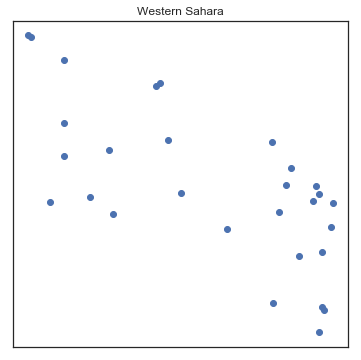

In [3]:
# Load in the Western Sahara dataset and plot it
wi29 = load_tsp_data('wi29.tsp')

plt.figure(1, figsize=(6,6))
plt.title('Western Sahara')
plot_lines(wi29, 'bo')

In [4]:
# Create a random tour, calculate its length and then plot it
random_tour = list((range(len(wi29))))
random.shuffle(random_tour)
tour_length(wi29, random_tour)

114910

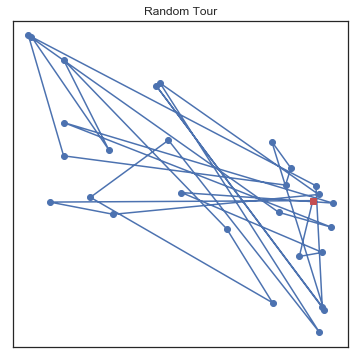

In [5]:
plt.figure(1, figsize=(6,6))
plt.title('Random Tour')
plot_tour(wi29, random_tour)

## Genetic operators in the OrderedIndividual
***
The OrderedIndividual's chromosome is constructed as an ordered set of numbers in the range 0..N-1, each of which represent the index a city in the dataset and consequently the route taken by the salesman.

### Mutation operators
  * Random Mutation: Randomly shuffle all the items in the list. This is never used in a search but is useful as a null-hypothesis to prove that the other operators do improve the search.
> e.g. 123456789 ==> **967248513**
  * Position Mutation: Pick two random items in the list and move them next to each other while maintaining the order of these two items
> e.g. 123**x**56**y**89 ==> 123**xy**5689 or 12356**xy**89
  * Order Mutation: Switch the order of two random items while maintaining their position.
> e.g. 123**x**56**y**89 ==> 123**y**56**x**89
  * Scramble Mutation: Take a random section of the chromosome and scramble its order.
> e.g. 123**4567**89 ==> 123**6475**89
  * Reverse Mutation: Similar to scramble mutation except that it reverses a section.
> e.g. 123**4567**89 ==> 123**7654**89

### Crossover operators
  * Position Crossover: Take two parents and crossover genes while maintaining the position in each parent's chromosome.
> e.g. Given, p1 = beagfdc & p2 = agdbfec, let m = 1000110 be a mask to represent which items are crossed over. **'afe'** from p2 (corresponding to the mask) is inserted in p1 in the same position and all other items in p1 are shifted down in their original order. So child1 = abgdfec and similarly child2 = bagefdc.

  * Order Crossover: Similar to Position Crossover except that the order is maintained in each parent.
> e.g. Given, p1 = beagfdc & p2 = agdbfec, let m = 1000110 be a mask to represent which items are crossed over. **'afe'** from p2 (corresponding to the mask) replace **'eaf'** p1 while all other items in p1 keep their original order ==> child1 = bafgedc and similarly child2 = agbfdec.
  * Edge Recombination Crossover: Assumes that the edges between two items (i.e. a pair of vertices) hold the key information and tries to maintain that relationship in the propogated genes. See [Wikipedia](https://en.wikipedia.org/wiki/Edge_recombination_operator) for details.


In _genoa_, for each operator, it is possible to fine tune the probability of it being chosen for reproduction. This can be varied over the life of the simulation and it is also possible to turn off any given operator completely.

Here are some graphs of how these operators perform in isolation and together...



In [6]:
progress = pd.read_csv('./results/wi29_progress.csv')

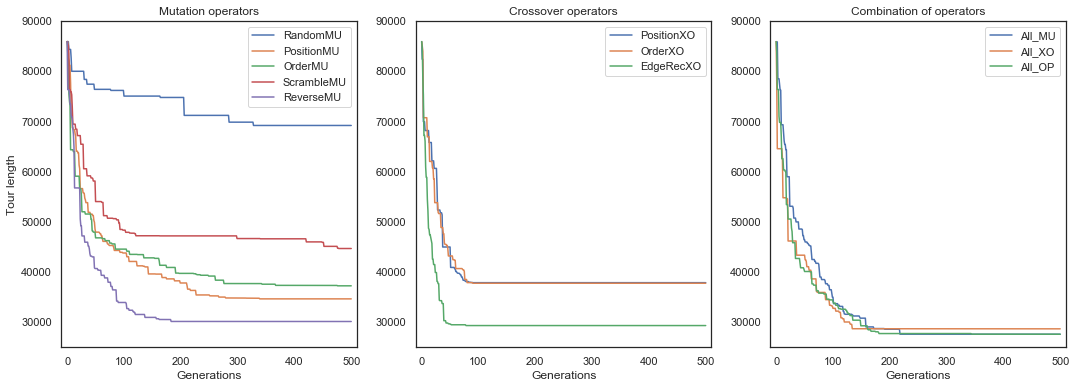

In [7]:
plt.figure(1, figsize=(18, 6))

plt.subplot(131)
plt.axis([-10, 510, 25000, 90000])
plt.plot(progress.values[:, 1:6])
plt.legend(progress.columns[1:6])
plt.title('Mutation operators')
plt.ylabel('Tour length')
plt.xlabel('Generations')

plt.subplot(132)
plt.axis([-10, 510, 25000, 90000])
plt.plot(progress.values[:, 6:9])
plt.legend(progress.columns[6:9])
plt.title('Crossover operators')
plt.xlabel('Generations')

plt.subplot(133)
plt.axis([-10, 510, 25000, 90000])
plt.plot(progress.values[:, 9:12])
plt.legend(progress.columns[9:12])
plt.title('Combination of operators')
plt.xlabel('Generations')

plt.show()


## Analysis of operator performance
---
All the above experiments were run for 500 generatations with an population size of 300 and a 25% replacement rate per generation, i.e. a total of **37,800** solutions (including duplicates) were evaluated out of a possible **3.0e+29** different tours.

Each operator was run in isolation (the first two graphs) followed by three combinations runs (all mutators, all crossovers and all operators). The same random seed was used, which guaranteed the same initial population as a starting point. Ideally, a Monte Carlo simulation should be run to get an expected value...

The optimal solution for this dataset is 27,603 and was found by two of the runs - the All Mutators (by the 240th generation) and the All Operators (by the 360th generation).

Some observations, questions and points for further analysis:

* All operators beat the Random Mutator... by some distance. Which proves that natural selection works?
* The Position and Order based mutators performed similarly. As did the the Position and Order based Crossovers. Is this an artefact of the TSP or this dataset?
* The crossover operators converge much faster than the mutators. Is there much **diversity** left in the population after ~100 generations in these runs?
* The Reverse and Scramble Mutators both operate on a random section of the chromosome - but the Reverse Mutator maintains most of the edge information (between each vertex pair), and outperforms the Scramble Mutator!
* The **edge information is important** - as also proved by the performance of the Edge Recombination Crossover

In fact a run using just the two operators - Reverse Mutation & Edge Recombination Operator - performed as well as the All Operators run.

**Which operators were most successful in improving the solution?** In a run where all operators had the same probability of being chosen, the number of times each operator produced an improved solution is shown below (the labels are abbreviated, but should be obvious)...

In [8]:
opdata = pd.read_csv('./results/wi29_opdist.csv')
c = Counter(opdata.operator)
opdist = sorted(c.items(), key=lambda x: x[1])

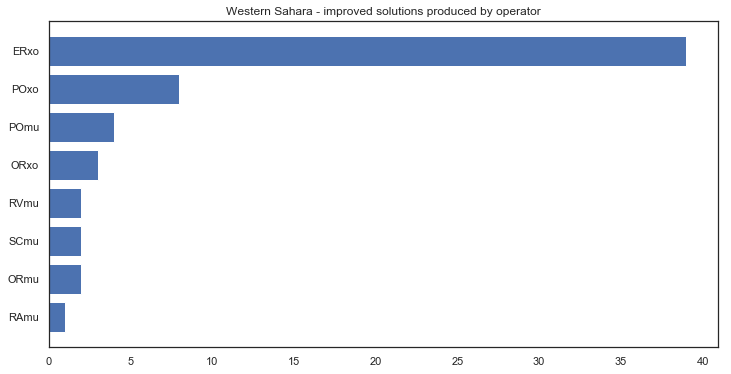

In [9]:
labels = [x[0] for x in opdist]
vals = [x[1] for x in opdist]

plt.figure(1, figsize=(12, 6))
plt.barh(range(len(vals)), vals, tick_label=labels)
plt.title('Western Sahara - improved solutions produced by operator')
plt.show()

## Solution to the Western Sahara dataset
---

So what does the optimal tour look like?

In [10]:
optimal_tour = [28,22,21,20,16,17,18,14,11,10,9,5,1,0,4,7,3,2,6,8,12,13,15,23,26,24,19,25,27]
tour_length(wi29, optimal_tour)

27603

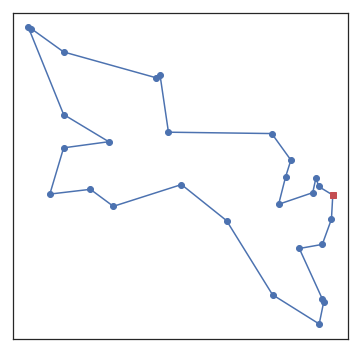

In [11]:
plt.figure(1, figsize=(6,6))
plot_tour(wi29, optimal_tour)

## The Qatar dataset
---
The Qatari dataset has 194 data points and **genoa** didn't find the optimal tour for this dataset. Having run the algorithhm for 9,000 generations with a population size of 500 and a replacement rate of 25%, a total of 1.13 million solutions would have been evaluated (out of a possible 6.9e+358). How well did it do?

The best solution had a length of 9,962 which is within ~7% of the [optimal tour of length 9,352](http://www.math.uwaterloo.ca/tsp/world/qatour.html). Let's take a look at the results...


In [12]:
qa194 = load_tsp_data('qa194.tsp')
qa_progress = pd.read_csv('./results/qa194_p1.csv')

# the best tour found
qa_best = """193 185 186 189 191 190 188 183 176 180 187 192 184 179 177 167 164 158 151 140 146
 150 154 157 161 166 169 170 165 159 147 142 132 128 134 135 130 121 118 113 112
 108 101 102 117 120 127 123 122 119 116 115 114 111 109  99 107 106 104 105  95
  94  96  91  87  92  90  77  74  71  73  68  59  32  27  21  28  44  56  63  69
  76  78  80  82  83  67  65  72  66  60  57  55  42  40  37  39  33  38  46  50
  36  26  30  34  43  45  47  52  51  53  54  48  49  41  31  29  18  14  11   9
   8   4  17  20  23  25  16  13  10   6   2   1   3   0   5   7  15  12  22  24
  70  75  86  79  81  61  58  35  62  19  64  84  85  97  89  88  93  98 100 103
 110 129 126 124 125 131 133 136 139 144 155 160 162 163 148 145 141 137 138 143
 149 152 153 156 174 172 173 182 178 171 168 175 181"""

# Length of the best tour 
qa_tour1 = list(int(i) for i in qa_best.split())
tour_length(qa194, qa_tour1)

9962

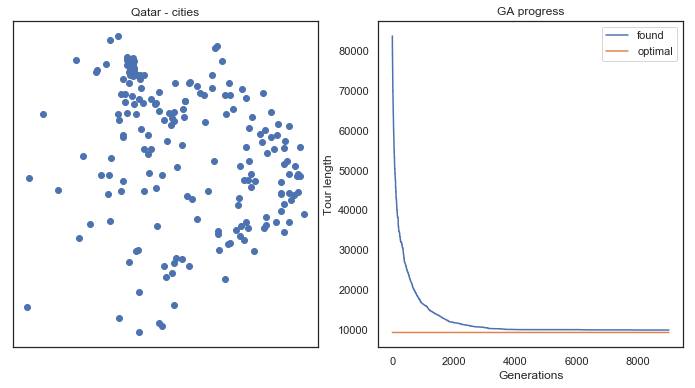

In [13]:
# Plot qa194 points
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.title('Qatar - cities')
plot_lines(qa194, 'bo')

# genoa progress
plt.subplot(122)
plt.plot(qa_progress.values[:, 1:3])
plt.legend(qa_progress.columns[1:3])
plt.title('GA progress')
plt.ylabel('Tour length')
plt.xlabel('Generations')

plt.show()

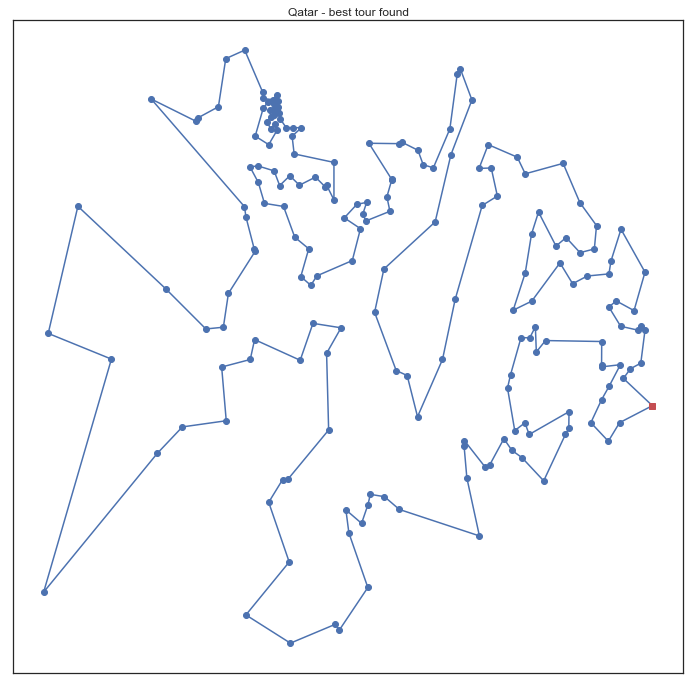

In [14]:
# the best tour
plt.figure(1, figsize=(12, 12))
plot_tour(qa194, qa_tour1)
plt.title('Qatar - best tour found')
plt.show()

## The Uruguay dataset
---
The Uruguay dataset has 734 data points; after six hours of number crunching, **genoa** completed only 7,857 generations, when the experiment was aborted. (Could do with some optimisation, but will leave that for later).

With a population size of 500 and a replacement rate of 25%, a total of ~980k solutions would have been evaluated (out of a possible 4.0e+1783). The best solution had a length of 162,349 which is more than double the [optimal tour length of 79,114](http://www.math.uwaterloo.ca/tsp/world/uytour.html) - clearly not acceptable.

Here are the results...


In [15]:
uy734 = load_tsp_data('uy734.tsp')
uy_progress = pd.read_csv('./results/uy734_p1.csv')

# the best tour 
uy_best = """733 723 682 693 675 683 674 568 419 428 427 444 424 408 375 307 319 281 302 278 248
 203 220 277 284 301 296 292 317 308 360 387 384 392 395 396 402 414 467 460 426
 381 366 390 382 372 379 376 404 528 529 624 637 650 684 706 680 698 689 685 668
 656 672 676 643 645 623 598 591 649 663 670 729 727 726 732 725 648 688 679 655
 652 596 582 661 673 681 697 708 704 720 712 709 719 694 696 695 703 707 714 724
 715 710 705 701 700 718 730 642 630 604 627 626 653 665 644 677 671 699 702 721
 713 716 731 728 717 687 659 537 551 533 434 377 399 368 369 370 330 291 264 233
 271 279 329 335 345 328 385 413 436 429 416 405 432 456 504 619 618 606 576 585
 587 641 636 561 577 599 556 574 611 620 536 507 492 479 461 489 499 522 535 525
 538 512 508 517 518 521 526 543 558 557 516 511 503 493 534 571 612 616 610 600
 559 578 583 588 579 629 631 632 621 617 622 613 575 584 601 566 589 423 445 446
 415 409 407 417 438 447 435 457 474 609 603 570 580 664 658 662 686 690 654 657
 628 509 524 520 505 483 449 431 433 422 412 359 338 276 283 243 242 238 250 141
 150 131 133 219 230 223 185 290 309 320 315 275 272 259 231 218 201 182 198 240
 303 362 358 350 341 340 343 346 388 332 306 406 451 463 357 318 209 249 257 289
 286 285 254 216 144 128 140 137 173 152 145 148 153 166 177 175 263 188 202 225
 193 222 224 237 217 210 172 151 197 200 176 147 143 184 205 258 310 298 287 282
 274 253 227 221 213 196 192 187 171 157 135 121  98  95 129 154 165 174 136 112
 103 118 111 107  87  60  32  31  34  47  56  48  91 235 251 300 339 389 410 400
 386 383 374 371 394 452 475 442 425 373 352 351 311 293 244 207 260 119 120  99
  42  38  39  13  12  11  14  94  65  71  52  55 123 122 161 194 190 195 239 321
 337 288 280 245 255 246 228 181 208 256 247 241 270 313 325 324 347 316 312 236
 252 214 212 262 269 261 180 191 186 183 132  84  83  76  15  17  10   5   2   0
   1   4   3   7   6   9   8  16  18  20  43  49  24  21  26  46  85  90 114  78
  92 117 109 108  57 164 179 168 170 126 169 211 189 104  73  74  53  62  66  67
  79  80  35  45  44  75  72  40  27  25  23  22  59  54  30  28  19  33  50  37
  41  70  97 156 167 162 160 142 124 106  58  51  36  86  93 105  77  96 116 113
 110 149 138 134 159 146 125  82  68 139 158 199 206 229 232 234 178 226 266 267
 204 155 130  89  88  64  69  61  29  63  81 102 100 101 115 127 163 215 349 398
 393 397 365 361 348 326 314 353 355 403 455 443 465 481 530 466 494 439 515 539
 552 545 544 607 592 548 593 527 595 667 660 692 678 647 635 634 638 669 646 625
 597 586 562 573 560 549 608 540 572 605 614 615 639 569 554 532 496 502 458 450
 437 441 421 506 485 477 510 487 488 491 478 497 547 563 555 541 513 498 484 464
 469 418 453 401 411 459 542 550 590 519 514 500 480 472 482 471 454 448 462 420
 378 356 336 295 294 268 265 305 342 364 380 391 367 363 331 304 344 334 273 299
 327 323 297 322 333 354 430 440 473 468 470 495 501 486 476 490 581 640 602 567
 553 546 531 523 564 594 565 633 666 651 691 711 722"""

# Length of the best tour found
uy_tour1 = list(int(i) for i in uy_best.split())
tour_length(uy734, uy_tour1)

162349

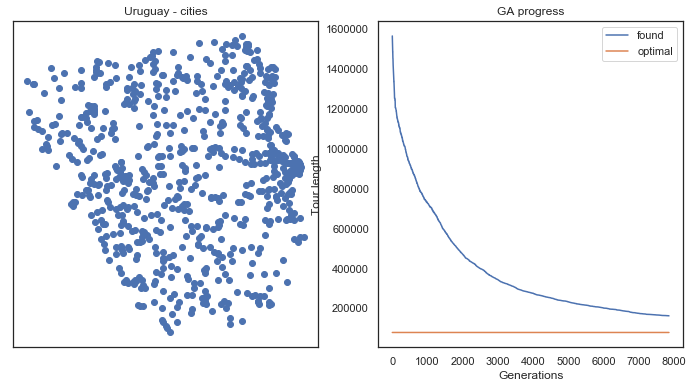

In [16]:
# Plot points
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.title('Uruguay - cities')
plot_lines(uy734, 'bo')

# genoa progress 
plt.subplot(122)
plt.plot(uy_progress.values[:, 1:3])
plt.legend(uy_progress.columns[1:3])
plt.title('GA progress')
plt.ylabel('Tour length')
plt.xlabel('Generations')

plt.show()

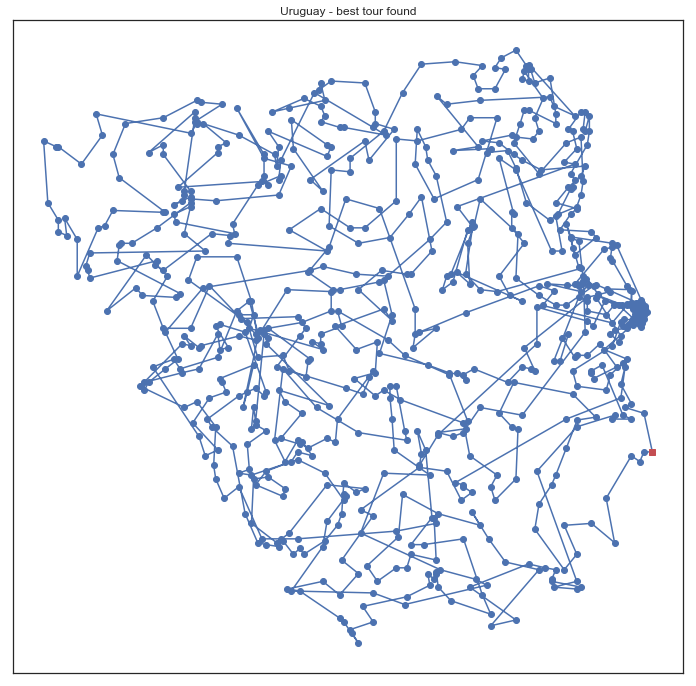

In [17]:
# the best tour
plt.figure(1, figsize=(12, 12))
plot_tour(uy734, uy_tour1)
plt.title('Uruguay - best tour found')

plt.show()

## Next steps...
---
For the Qatari dataset the algorithm made decent progress; but was way off the optimal solution for the Uruguayan. Can we try and improve this?

In **genoa** it is possible to start with a seeded initial population, instead of a total random one. It should be relatively easy to create a **hybrid** methodology to seed the population with some sub-optimal tours - but that is for another time (and another notebook!)

